In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC, l1_min_c
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import warnings 
warnings.simplefilter('ignore')

# plot settings 
sns.set_style("dark")
sns.despine()
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 5})

In [2]:
# set seed
seed = 123
np.random.seed(seed)

### Load data
The first fourteen columns include metrics that describe the action potential and calcium transient waveforms. The last three columns are the susceptibility to three arrhythmic triggers - (1) IKr Block (2) ICaL Increase (3) Current Injection. *0 = no arrhythmia formed (low risk) and 1 = arrhytmia formed (high risk).*

In [7]:
# read the data
filename = 'C:/TestPopulation/Data/Population_ScalingParameters.csv'
df = pd.read_csv(filename)
df = df.dropna()

In [8]:
df.columns

Index(['GNa', 'GNaL', 'Gto', 'GKr_', 'GKs_', 'GK1', 'Gncx', 'GKb', 'GpCa',
       'PCa_', 'Pnak', 'PNab', 'PCab', 'SERCA_total', 'RyR_total',
       'Leak_total', 'Trans_total', 'pm', 'ph', 'pj', 'php', 'pjp', 'pmL',
       'phL', 'phLp', 'pa', 'pif', 'pis', 'pap', 'pipf', 'pips', 'pd', 'pf',
       'pfcaf', 'pfcas', 'pjca', 'pfpf', 'pfcapf', 'pxrf', 'pxrs', 'pxs1',
       'pxs2', 'pxk1', 'Vm', 'Vh', 'Vj', 'Vhp', 'Vjp', 'VmL', 'VhL', 'VhLp',
       'Va', 'Vi', 'Vap', 'Vip', 'Vd', 'Vf', 'Vfca', 'Vjca', 'Vfp', 'Vfcap',
       'Vxr', 'Vxs1', 'Vxs2', 'Vncx', 'Vnak', 'IKrBlock_Label',
       'ICaLIncrease_Label', 'Inject_Label'],
      dtype='object')

In [9]:
y_labels = [c for c in df.columns if "Label" in c]
y_0 = df[y_labels[0]] # Label for GKr
y_1 = df[y_labels[1]] # Label for PCa
y_2 = df[y_labels[2]] # Label for Inject

In [10]:
output_name = 'ScalingParametersFeatures'
df1 = df.drop(y_labels, axis=1) 

In [11]:
df1.head()

GNa      GNaL       Gto      GKr_      GKs_       GK1      Gncx  \
0  0.533923  1.260602  0.927986  1.517936  1.596289  1.845988  1.325473   
1  1.397156  1.123443  0.983639  1.038316  0.983304  0.792393  0.897053   
2  1.107188  0.942286  0.738587  0.985334  0.489456  1.003678  1.169405   
3  0.544090  1.849409  0.771695  1.158308  0.992485  0.855011  1.503346   
4  1.115249  1.328436  1.621054  0.785026  1.621587  1.453442  1.084050   

        GKb      GpCa      PCa_  ...        Vf      Vfca      Vjca       Vfp  \
0  1.122259  1.333815  1.310017  ... -0.136952 -4.294755  6.273861 -2.526759   
1  0.846821  0.610639  1.013694  ...  3.891970 -0.279158 -0.830552  0.205218   
2  0.859819  1.307003  0.934490  ... -0.170324  1.286596 -1.070722  2.511820   
3  1.209077  1.146396  1.159602  ... -2.368136 -0.347998  5.268992  5.189137   
4  0.847705  1.562143  0.566997  ... -5.035449 -4.146750 -4.485763  0.946909   

      Vfcap       Vxr      Vxs1      Vxs2      Vncx      Vnak  
0 -1.007345  0.883630 -1.636644 -5.172658  0.046596 -6.023949  
1  3.957064  1.929600  3.914690  5.268908 -0.704478  2.107406  
2  2.652591  1.127061  4.635116 -0.380988  2.819395 -5.057381  
3  2.978851 -1.961988  2.347744 -2.289881  2.336622 -2.868062  
4 -1.165476  3.653341 -2.278459 -0.884528 -0.094103 -4.664124  

[5 rows x 66 columns]

### Run lasso regression

In [12]:
x = df1 
x_1 = StandardScaler().fit_transform(x) # for other classifiers except ANN
xtrain, xtest, ytrain, ytest = train_test_split(x_1, y_0, random_state = seed, test_size = 0.10)

In [13]:
def run_pipeline(df1,y):
    x = df1 
    x_1 = StandardScaler().fit_transform(x) # for other classifiers except ANN

    xtrain, xtest, ytrain, ytest = train_test_split(x_1, y, random_state = seed, test_size = 0.10)

#     cs = l1_min_c(xtrain, ytrain, loss='log') * np.logspace(0, 10, 30)
    cs = np.linspace(1e-5,1e-1,50)
    clf = LogisticRegression(penalty='l1', solver='saga',
                                          tol=1e-6, max_iter=int(1e6),
                                          warm_start=True,
                                          intercept_scaling=10000.)
    coefs_ = []
    aucs = []
    for c in cs:
        clf.set_params(C=c)
        clf.fit(xtrain, ytrain)
        pred = clf.predict(xtest)
        prob = clf.predict_proba(xtest)
        accuracy = accuracy_score(ytest, pred)
        f1 = f1_score(ytest, pred)
        precision = precision_score(ytest, pred)
        recall = recall_score(ytest,pred)
        tn, fp, fn, tp = confusion_matrix(ytest, pred).ravel()
        sen = tp/(tp + fn)
        spe = tn/(tn + fp)
        npv = tn/(tn + fn)
        ppv = tp/(tp + fp)
        fpr, tpr, thresholds = roc_curve(ytest, prob[:,1])
        auc_score = auc(fpr, tpr)

        print('Test set AUC: %.2f %%' % (auc_score * 100))

        coefs_.append(clf.coef_.ravel().copy())
        aucs.append(auc_score)

    index = next(x for x, val in enumerate(aucs) if round(val,3) >= 0.955)
    print(index)
    n_parameters = len(coefs_[index][coefs_[index]!=0])

    df = pd.DataFrame(coefs_[index],columns=['values'],index = df1.columns)
    df = df.loc[~(df==0).all(axis=1)]
    df['abs_values'] = df['values'].abs()
    ordered_df = df.sort_values(by='abs_values',ascending=True)

    return n_parameters, ordered_df

In [14]:
[n_IKr,df_IKr] = run_pipeline(df1,y_0)
[n_ICaL,df_ICaL] = run_pipeline(df1,y_1)
[n_Inject,df_Inject] = run_pipeline(df1,y_2)

Test set AUC: 50.00 %
Test set AUC: 96.06 %
Test set AUC: 98.40 %
Test set AUC: 98.95 %
Test set AUC: 99.15 %
Test set AUC: 99.24 %
Test set AUC: 99.29 %
Test set AUC: 99.31 %
Test set AUC: 99.32 %
Test set AUC: 99.32 %
Test set AUC: 99.33 %
Test set AUC: 99.33 %
Test set AUC: 99.33 %
Test set AUC: 99.33 %
Test set AUC: 99.33 %
Test set AUC: 99.33 %
Test set AUC: 99.33 %
Test set AUC: 99.33 %
Test set AUC: 99.32 %
Test set AUC: 99.32 %
Test set AUC: 99.32 %
Test set AUC: 99.32 %
Test set AUC: 99.32 %
Test set AUC: 99.32 %
Test set AUC: 99.31 %
Test set AUC: 99.31 %
Test set AUC: 99.31 %
Test set AUC: 99.31 %
Test set AUC: 99.31 %
Test set AUC: 99.31 %
Test set AUC: 99.31 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set AUC: 99.30 %
Test set A

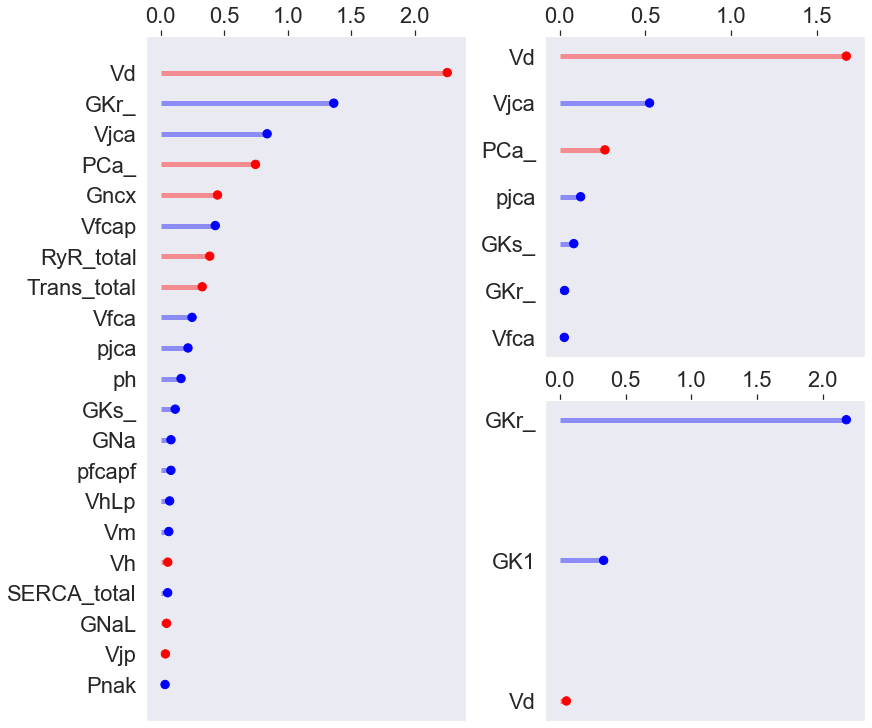

In [15]:
fig3 = plt.figure(constrained_layout=True,figsize=(12,10))
gs = fig3.add_gridspec(2, 2)

f3_ax1 = fig3.add_subplot(gs[:,0])
my_range=range(1,len(df_ICaL.index)+1)
my_color=np.where(df_ICaL['values']>=0, 'red', 'blue')
plt.hlines(y=my_range, xmin=0, xmax=df_ICaL['abs_values'], color=my_color, alpha=0.4)
plt.scatter(df_ICaL['abs_values'], my_range, color=my_color, s=70, alpha=1)
plt.yticks(my_range, df_ICaL.index)
f3_ax1.xaxis.tick_top()
f3_ax1.xaxis.set_label_position('top')

f3_ax2 = fig3.add_subplot(gs[0, 1])
my_range=range(1,len(df_IKr.index)+1)
my_color=np.where(df_IKr['values']>=0, 'red', 'blue')
plt.hlines(y=my_range, xmin=0, xmax=df_IKr['abs_values'], color=my_color, alpha=0.4)
plt.scatter(df_IKr['abs_values'], my_range, color=my_color, s=70, alpha=1)
plt.yticks(my_range, df_IKr.index)
f3_ax2.xaxis.tick_top()
f3_ax2.xaxis.set_label_position('top')

f3_ax3 = fig3.add_subplot(gs[1, 1])
my_range=range(1,len(df_Inject.index)+1)
my_color=np.where(df_Inject['values']>=0, 'red', 'blue')
plt.hlines(y=my_range, xmin=0, xmax=df_Inject['abs_values'], color=my_color, alpha=0.4)
plt.scatter(df_Inject['abs_values'], my_range, color=my_color, s=70, alpha=1)
plt.yticks(my_range, df_Inject.index)
f3_ax3.xaxis.tick_top()
f3_ax3.xaxis.set_label_position('top')

sns.set_style("ticks")
sns.set_context("talk")

([<matplotlib.axis.XTick at 0x1e88c31ac88>,
 <a list of 3 Text xticklabel objects>)

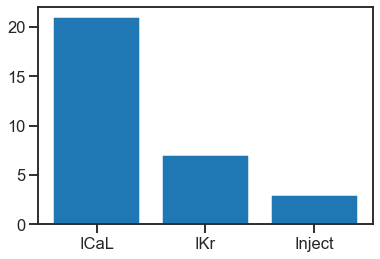

In [16]:
bars = ('ICaL', 'IKr', 'Inject')
y_pos = np.arange(len(bars))
plt.bar(y_pos, np.array([n_ICaL,n_IKr,n_Inject]))
plt.xticks(y_pos, bars)

In [17]:
# make a new cmap 
cmap2 = sns.diverging_palette(10, 220, sep=80, n=20,as_cmap=True)
cmap1 = sns.diverging_palette(10, 220, sep=80, n=2,l=65,as_cmap=True)

cmap11 = sns.diverging_palette(240, 10, n=75,as_cmap=True)
cmap12 = sns.diverging_palette(240, 10, n=9,l = 70,as_cmap=True)

### Run logisitc regression on top 2 parameters 

In [19]:
def runLR_2params(df1,y,params,title):
    
    x_1 = StandardScaler().fit_transform(df1) # for other classifiers except ANN
    xtrain, xtest, ytrain, ytest = train_test_split(x_1, y, random_state = seed, test_size = 0.10)

    clf = LogisticRegression(C = 0.01, penalty='l1', solver='liblinear',
                                          tol=1e-6, max_iter=int(1e6),
                                          warm_start=True,
                                          intercept_scaling=10000.)
    clf.fit(xtrain[:,params], ytrain)
    
    
    xx, yy = np.mgrid[-5:5:.1, -5:5:.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)


    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 50, cmap=cmap11,
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(xtest[0:50,params[0]], xtest[0:50,params[1]], c=ytest[0:50], s=50,
               cmap=cmap12, vmin=-.2, vmax=1.2,
               edgecolor="black", linewidth=1)

    ax.set(aspect="equal",
           xlim=(-5, 5), ylim=(-5, 5),
           xlabel=str(df1.columns[params[0]]), ylabel=str(df1.columns[params[1]]))

    y_pred = clf.predict(xtest[:,params])
    y_prob = clf.predict_proba(xtest[:,params])


    # Compute the accuracy of the prediction
    accuracy = accuracy_score(ytest, y_pred)
    print('Test set accuracy: %.2f %%' % (accuracy * 100))
    fpr, tpr, thresholds = roc_curve(ytest, y_prob[:,1])
    auc_score = auc(fpr, tpr)
    print('Test set AUC: %.2f %%' % (auc_score * 100))

IKr Block
Test set accuracy: 85.36 %
Test set AUC: 93.76 %


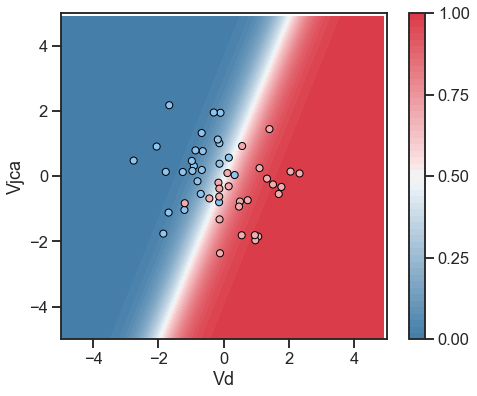

In [21]:
print('IKr Block')
runLR_2params(df1,y_0,[55,58],'IKr_Block_Scatter')

ICaL Increase
Test set accuracy: 77.24 %
Test set AUC: 85.44 %


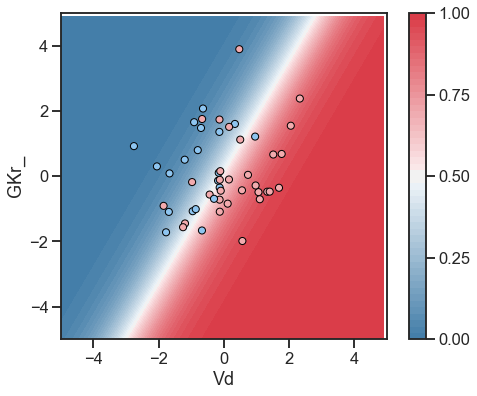

In [22]:
print('ICaL Increase')
runLR_2params(df1,y_1,[55,3],'ICaL_Increase_Scatter')

Inject
Test set accuracy: 90.37 %
Test set AUC: 96.85 %


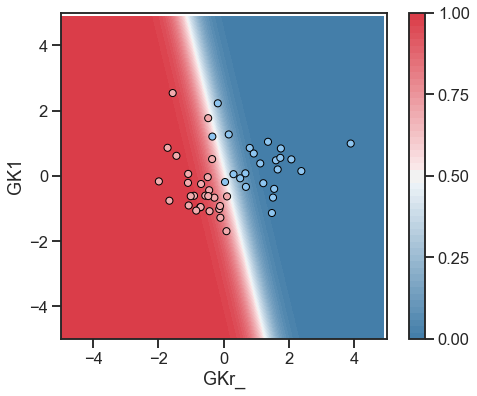

In [23]:
print('Inject')
runLR_2params(df1,y_2,[3,5],'Inject_Scatter')